In [ ]:
#Load essential tools for project
import time
import os
import shutil
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

import torch.utils.data as data
from torchvision.datasets import ImageFolder
from PIL import Image

use_cuda = True


In [ ]:
#Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


For the project report, we want to focus on making sure we can produce a solid classification accuracy for our dataset. So currently, we are limiting our scope to taking inputs of 224x224 images where the sign is centered, this is a part of our data cleaning and processing process and is demonstrated in our transformations section of the code.


In [ ]:
#set up our transforms
transform = transforms.Compose(
        [transforms.ToTensor(), #maniputable tensor structure
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
         #normalize to [-1,1] for each pixel for faster processing
         transforms.Lambda(lambda x: x[:3]),
        transforms.CenterCrop(224),
         transforms.Resize((224, 224))]) #crop to 224x224


#load the data with imagefolder
train_dataset = torchvision.datasets.ImageFolder('/content/drive/MyDrive/APS360 Project/Data/train',

                                                 transform=transform)

val_dataset = torchvision.datasets.ImageFolder('/content/drive/MyDrive/APS360 Project/Data/val',

                                               transform=transform)



test_dataset = torchvision.datasets.ImageFolder('/content/drive/MyDrive/APS360 Project/Data/test',

                                                transform=transform)


The following code prints our data distribution, as we aim for a 80%-10%-10% spread for training, validation, and testing data respectively

In [ ]:
total_data = len(train_dataset) + len(val_dataset) + len(test_dataset)

print("Training data makes up", round(len(train_dataset)/total_data*100,2), "% of all data.")
print("Validation data makes up", round(len(val_dataset)/total_data*100,2), "% of all data.")
print("Test data makes up", round(len(test_dataset)/total_data*100,2), "% of all data.")

Training data makes up 75.0 % of all data.
Validation data makes up 12.5 % of all data.
Test data makes up 12.5 % of all data.


To realize our model, we intend to use the prexisting AlexNet, a neural network which is adept at classification techniques and that of which the team has much experience working with from past labs. We define our classes, load our data, and save our features in the code below

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 88.5MB/s]


In [ ]:
!mkdir ./AlexNet
!mkdir ./AlexNet/Features
!mkdir ./AlexNet/Features/train
!mkdir ./AlexNet/Features/val
!mkdir ./AlexNet/Features/test

!mkdir ./AlexNet/Features/train/TRAFFICSIGNAL
!mkdir ./AlexNet/Features/train/STOP
!mkdir ./AlexNet/Features/train/PEDESTRIAN
!mkdir ./AlexNet/Features/train/KEEPRIGHT
!mkdir ./AlexNet/Features/train/SPEED40
!mkdir ./AlexNet/Features/train/SPEED60


!mkdir ./AlexNet/Features/val/TRAFFICSIGNAL
!mkdir ./AlexNet/Features/val/STOP
!mkdir ./AlexNet/Features/val/PEDESTRIAN
!mkdir ./AlexNet/Features/val/KEEPRIGHT
!mkdir ./AlexNet/Features/val/SPEED60
!mkdir ./AlexNet/Features/val/SPEED40



!mkdir ./AlexNet/Features/test/SPEED40
!mkdir ./AlexNet/Features/test/SPEED60
!mkdir ./AlexNet/Features/test/TRAFFICSIGNAL
!mkdir ./AlexNet/Features/test/STOP
!mkdir ./AlexNet/Features/test/PEDESTRIAN
!mkdir ./AlexNet/Features/test/KEEPRIGHT



mkdir: cannot create directory ‘./AlexNet’: File exists
mkdir: cannot create directory ‘./AlexNet/Features’: File exists
mkdir: cannot create directory ‘./AlexNet/Features/train’: File exists
mkdir: cannot create directory ‘./AlexNet/Features/val’: File exists
mkdir: cannot create directory ‘./AlexNet/Features/test’: File exists
mkdir: cannot create directory ‘./AlexNet/Features/train/TRAFFICSIGNAL’: File exists
mkdir: cannot create directory ‘./AlexNet/Features/train/STOP’: File exists
mkdir: cannot create directory ‘./AlexNet/Features/train/PEDESTRIAN’: File exists
mkdir: cannot create directory ‘./AlexNet/Features/train/KEEPRIGHT’: File exists
mkdir: cannot create directory ‘./AlexNet/Features/train/SPEED40’: File exists
mkdir: cannot create directory ‘./AlexNet/Features/train/SPEED60’: File exists
mkdir: cannot create directory ‘./AlexNet/Features/val/TRAFFICSIGNAL’: File exists
mkdir: cannot create directory ‘./AlexNet/Features/val/STOP’: File exists
mkdir: cannot create directory

In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [ ]:
#define our classes (traffic signals)
classes = ['KEEPRIGHT', 'PEDESTRIAN', 'STOP', 'TRAFFICSIGNAL', 'SPEED40', 'SPEED60']


#function to extract alexnet features from our data, save to folder.
def alex_features(data):
    if data == "train":
        data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
    elif data == "val":
        data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=True)
    elif data == "test":
        data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)
    else:
        print("Error, invalid dataset name")
        return None
    #iterate through loaded data, save alex net features
    n = 0
    for imgs, labels in iter(data_loader):
        features = alexnet.features(imgs)
        features_tensor = torch.from_numpy(features.detach().numpy())
        torch.save(features_tensor.squeeze(0), './AlexNet' + '/Features/' + data + '/' + classes[labels] + '/' + 'feature_bs1_' + str(n) + '.tensor')
        n += 1

In [ ]:
#get our features
alex_features("train")
alex_features("val")
alex_features("test")

In [ ]:
!rm -R /content/AlexNet/Features/test/.ipynb_checkpoints
!rm -R /content/AlexNet/Features/train/.ipynb_checkpoints
!rm -R /content/AlexNet/Features/val/.ipynb_checkpoints


rm: cannot remove '/content/AlexNet/Features/test/.ipynb_checkpoints': No such file or directory


In [ ]:
#load our features

train_features = torchvision.datasets.DatasetFolder('/content/AlexNet/Features/train', loader=torch.load,
                                                    extensions=('.tensor'))
val_features = torchvision.datasets.DatasetFolder('/content/AlexNet/Features/val', loader=torch.load,
                                                  extensions=('.tensor'))
test_features = torchvision.datasets.DatasetFolder('/content/AlexNet/Features/test', loader=torch.load,
                                                   extensions=('.tensor'))


In [ ]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.name = "AlexNet"
        self.conv1 = nn.Conv2d(256, 256, 5, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 2 * 2, 64)
        self.fc2 = nn.Linear(64, 9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 256 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

We define our training and accuracy functions below:


In [ ]:
def get_accuracy_ALEX(model, batch_size, train=False):
    if train:
        data = train_features
    else:
        data = val_features
    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=batch_size):


        #############################################
        # To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################


        output = model(imgs)

        # Select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

#gonna update learning rate to be a little higher (3e^-4), num epochs to 25 because
#training takes a while, validation levels out early
def train_ALEX(model, data, batch_size=64, learning_rate=0.05, num_epochs=25):
    torch.manual_seed(1000)
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    iters, losses, train_acc, val_acc = [], [], [], []

    # Training
    start_time = time.time()
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):


            #############################################
            # To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################


            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # Save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            n += 1
        train_acc.append(get_accuracy_ALEX(model, batch_size=batch_size, train=True)) # compute training accuracy
        val_acc.append(get_accuracy_ALEX(model, batch_size=batch_size, train=False))  # compute validation accuracy

        # Save the current model (checkpoint) to a file
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    # Plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(range(1 ,num_epochs+1), train_acc, label="Train")
    plt.plot(range(1 ,num_epochs+1), val_acc, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

Currently, we have opted for a safe starting pointing for an optimizer in the ADAM optimizer. We use crossentropy loss because of the multitude of classes we have. As we progress, we will look to introduce dropout to regularize our model, data augmentation to increase our training data size and prevent overfitting, increasing the complexity of our model, and batch normalization. For now, we simply want to demonstrate a starting point for our model and the potential for increasing accuracy/success


The following code blocks are training results for our model as they change with the tuning of hyperparamters. We begin with a learning rate of 3e^-4, standard for ML models, a batch size of 64, and 20 epochs.

We will continue to tune the parameters, whatever is in the code is latest hyperparameters chosen

USING CUDA
Finished Training
Total time elapsed: 4.15 seconds


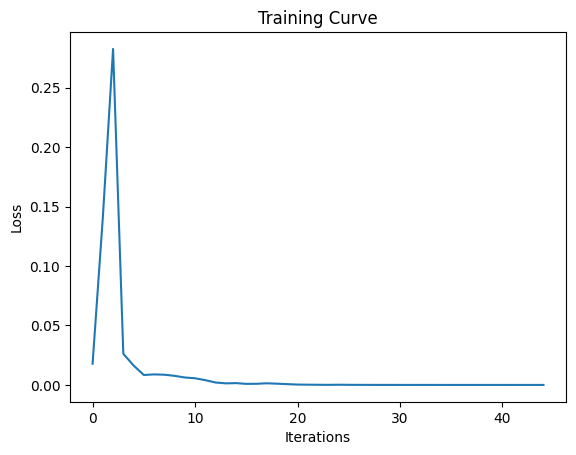

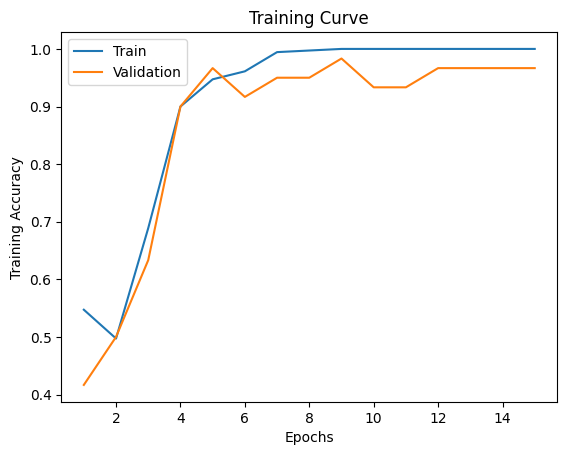

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.9666666666666667


In [ ]:
alex_model = AlexNet()
use_cuda=True
if use_cuda and torch.cuda.is_available():
  alex_model.cuda()
  print('USING CUDA')
else:
  print('NO CUDA')
  #best model tested actually had following parameters

#first training with parameters listed above
train_ALEX(alex_model, train_features, batch_size=128, learning_rate=0.01, num_epochs=15)

Get our test accuracy with the following function:

In [ ]:
def get_accuracy_ALEX_test(model, batch_size):
   # if train:
      #  data = train_features
  #  else:
     #   data = val_features
    data = test_features
    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=batch_size):


        #############################################
        # To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################


        output = model(imgs)

        # Select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

Lets also test a baseline model, a simple CNN network developed in labs with some tuning to get the best possible result.

In [ ]:
class TR_CNN(nn.Module):
    def __init__(self):
        super(TR_CNN, self).__init__()
        self.name = "Traffic Sign CNN"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 53 * 53, 32)
        self.fc2 = nn.Linear(32, 9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

We define a few functions that are fairly straightforward and similar to our alexnet functions, for ease of implentation of the baseline

In [ ]:
use_cuda = True
def get_accuracy(model, batch_size, train=False):
    if train:
        data = train_dataset
    else:
        data = val_dataset
    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=batch_size):


        #############################################
        # To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################


        output = model(imgs)

        # Select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

def train(model, data, batch_size=64, learning_rate=0.001, num_epochs=30):
    torch.manual_seed(1000)
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    iters, losses, train_acc, val_acc = [], [], [], []

    # Training
    start_time = time.time()
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):


            #############################################
            # To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################


            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # Save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            n += 1
        train_acc.append(get_accuracy(model, batch_size=batch_size, train=True)) # compute training accuracy
        val_acc.append(get_accuracy(model, batch_size=batch_size, train=False))  # compute validation accuracy

        # Save the current model (checkpoint) to a file
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    # Plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(range(1 ,num_epochs+1), train_acc, label="Train")
    plt.plot(range(1 ,num_epochs+1), val_acc, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

Now we begin training, tuning our hyperparameters to obtain as of an accuracy as possible

USING CUDA
Finished Training
Total time elapsed: 278.74 seconds


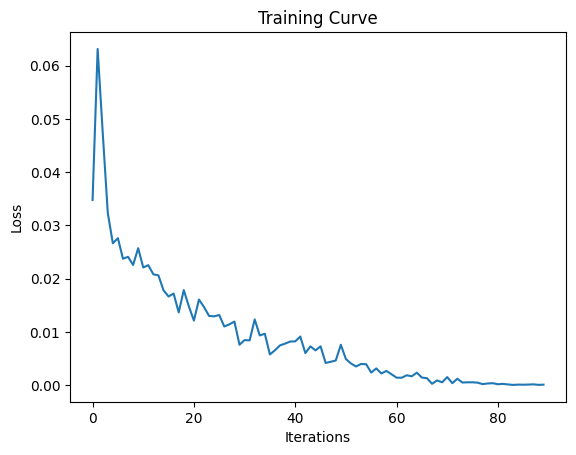

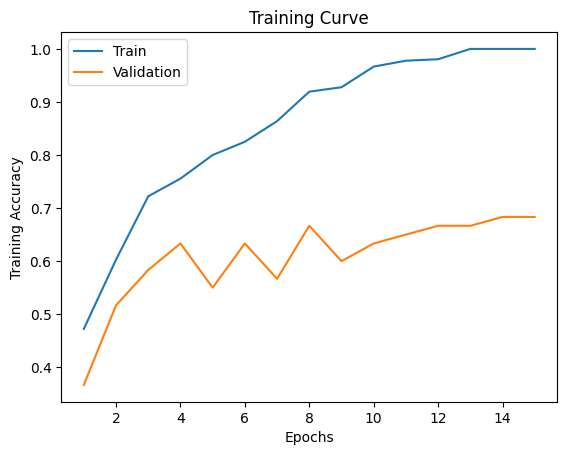

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.6833333333333333


In [ ]:
baseline = TR_CNN()
use_cuda=True
if use_cuda and torch.cuda.is_available():
  baseline.cuda()
  print('USING CUDA')
else:
  print('NO CUDA')

#begin with identical hyperparameters to our primary model

train(baseline, train_dataset, batch_size=64, learning_rate=0.005, num_epochs=15)